In [23]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import os

from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision import datasets, transforms
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch

In [24]:
print('GPU disponible : ', torch.cuda.is_available(), '\nVersion de CUDA : ', torch.version.cuda)

GPU disponible :  True 
Version de CUDA :  11.8


### Préparation du dataset

In [25]:
# Fonction pour mapper l'âge aux classes d'âge d'Adience
def adience_age_group(age):
    if age <= 2:
        return 0  # 0-2 ans
    elif age <= 6:
        return 1  # 4-6 ans
    elif age <= 13:
        return 2  # 8-13 ans
    elif age <= 20:
        return 3  # 15-20 ans
    elif age <= 32:
        return 4  # 25-32 ans
    elif age <= 43:
        return 5  # 38-43 ans
    elif age <= 53:
        return 6  # 48-53 ans
    else:
        return 7  # 60 ans et plus

# Classe Dataset personnalisée pour UTKFace
class UTKFaceDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images = []
        self.labels = []

        # Lire les noms de fichiers et extraire les étiquettes
        for file_name in os.listdir(dataset_path):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                age = int(file_name.split('_')[0])
                self.images.append(os.path.join(dataset_path, file_name))
                self.labels.append(adience_age_group(age))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformer pour les images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chargement du dataset
dataset_path = './dataset/archive/utkcropped/'
utk_dataset = UTKFaceDataset(dataset_path=dataset_path, transform=transform)

# Division du dataset
train_size = int(0.7 * len(utk_dataset))
valid_size = int(0.15 * len(utk_dataset))
test_size = len(utk_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(utk_dataset, [train_size, valid_size, test_size])

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Time benchmarking (ou identification du CPU comme bottleneck du temps d'entraînement)

In [26]:
start_time = time.time()
for i, batch in enumerate(test_loader):
    pass
print(f"Temps pour itérer sur le test_loader: {time.time() - start_time} secondes")

Temps pour itérer sur le test_loader: 11.401038885116577 secondes


### Visualisation pour tester qu'on a bien preprocess

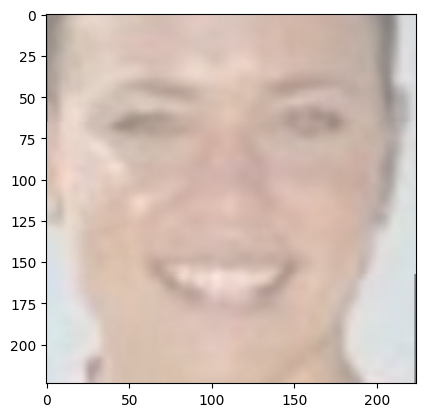

Integer représentant la classe :  5
Age :  25  -  30


In [27]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def unnormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone()  
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)   
    return tensor

i = 1
for inputs, targets in test_loader:
    imshow(unnormalize(inputs[i]))
    print('Integer représentant la classe : ', targets[i].item())
    print('Age : ', targets[i].item()*5, ' - ', (1+targets[i].item())*5)

    break

### Modèles

In [28]:
import torch.nn as nn
from torch.utils.checkpoint import checkpoint

############ CNN ###########

class CNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CNN, self).__init__()
        
        # Convolutions
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(3, 3)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Dropout
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(1024, 512) 
        self.fc2 = nn.Linear(512, num_classes)

        # Bloc de convolution Conv+Bn+ReLU+Pool
        def forward_conv_block(self, x, conv, bn):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)
            x = self.pool(x)
            return x

    def forward(self, x):

        # Gradient checkpointing pour consommer moins de mémoire GPU
        x = checkpoint(self.forward_conv_block, x, self.conv1, self.bn1)
        x = checkpoint(self.forward_conv_block, x, self.conv2, self.bn2)
        x = checkpoint(self.forward_conv_block, x, self.conv3, self.bn3)
        x = checkpoint(self.forward_conv_block, x, self.conv4, self.bn4)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout2(x)
        x = self.fc2(x) 

        return x

#################### CapsNet ##########
    
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, num_route_nodes, in_channels, out_channels, kernel_size=None, stride=None, num_iterations=3):
        super(CapsuleLayer, self).__init__()

        self.num_route_nodes = num_route_nodes
        self.num_iterations = num_iterations

        if num_route_nodes != -1:
            self.route_weights = nn.Parameter(torch.randn(num_capsules, num_route_nodes, in_channels, out_channels))
        else:
            self.capsules = nn.ModuleList([
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=0)
                for _ in range(num_capsules)
            ])

    def squash(self, tensor, dim=-1):
        squared_norm = (tensor ** 2).sum(dim=dim, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * tensor / torch.sqrt(squared_norm)

    def forward(self, x):
        if self.num_route_nodes != -1:
            priors = x[None, :, :, None, :] @ self.route_weights[:, None, :, :, :]
            logits = torch.zeros(*priors.size()).to(x.device)
            for i in range(self.num_iterations):
                probs = F.softmax(logits, dim=2)
                outputs = self.squash((probs * priors).sum(dim=2, keepdim=True))

                if i != self.num_iterations - 1:
                    delta_logits = (priors * outputs).sum(dim=-1, keepdim=True)
                    logits = logits + delta_logits
            return outputs.squeeze(3)
        else:
            # Apply convolution and squash for the first layer of capsules
            # This section is modified to support checkpointing
            outputs = [checkpoint(capsule, x).view(x.size(0), -1, 1) for capsule in self.capsules]
            outputs = torch.cat(outputs, dim=-1)
            return self.squash(outputs)

class CapsNet(nn.Module):
    def __init__(self, num_classes=21, num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32):
        super(CapsNet, self).__init__()
        
        # Initial convolution layer
        self.conv_layer = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=9, stride=1)
        
        # Primary capsule layer
        self.primary_capsules = CapsuleLayer(num_capsules=8, num_route_nodes=-1, in_channels=256, out_channels=32, kernel_size=9, stride=2)
        
        # Digit capsule layer (final layer of capsules)
        self.digit_capsules = CapsuleLayer(num_capsules=num_classes, num_route_nodes=32 * 24 * 24, in_channels=8, out_channels=16)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16 * num_classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = F.relu(checkpoint(self.conv_layer, x))
        x = self.primary_capsules(x)
        x = self.digit_capsules(x).squeeze().transpose(0, 1)
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        return classes




### Fonction d'entraînement

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.cuda.amp import GradScaler, autocast

def train(hyperparameters):

    lr = hyperparameters['lr']
    weight_decay = hyperparameters['weight_decay']
    step_size = hyperparameters['step_size']
    gamma = hyperparameters['gamma']
    
    model = CNN().to(device)
    #model = CapsNet().to(device)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler() # Initialize the gradient scaler for AMP

    patience = 10
    patience_counter = 0
    best_valid_loss = float('inf')

    for epoch in range(10): # Nombre d'epoch
        model.train()
        train_loss = 0
        n=len(train_loader)
        for i, batch in enumerate(train_loader):
            print(f'Epoch {epoch+1} : {round(100*i/n, 3)} %', end='\r')
            data, target = batch
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            with autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
            
        # Comparaison pour le contrôle de l'overfitting
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter > patience :
            print("Stopping early due to no improvement")
            break
        if train_loss<0.6*valid_loss :
            print("Stopping early due to overfitting")
            break
        
        scheduler.step()

        print(f'Epoch {epoch}, Train Loss: {round(train_loss, 5)}, Validation Loss: {round(valid_loss, 5)}, Patience : {patience_counter}', end='\r') 
    
    return model, valid_loss

### Entrainement évaluation et plot

In [30]:
##### Initial parameters #####
parameters = {'lr' : 1e-3,
                        'weight_decay' : 1e-2,
                        'step_size' : 30,
                        'gamma' : 0.2
    }

model, valid_loss = train(hyperparameters = parameters)  

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set model to evaluation mode
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader: 
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predictions = torch.max(output, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

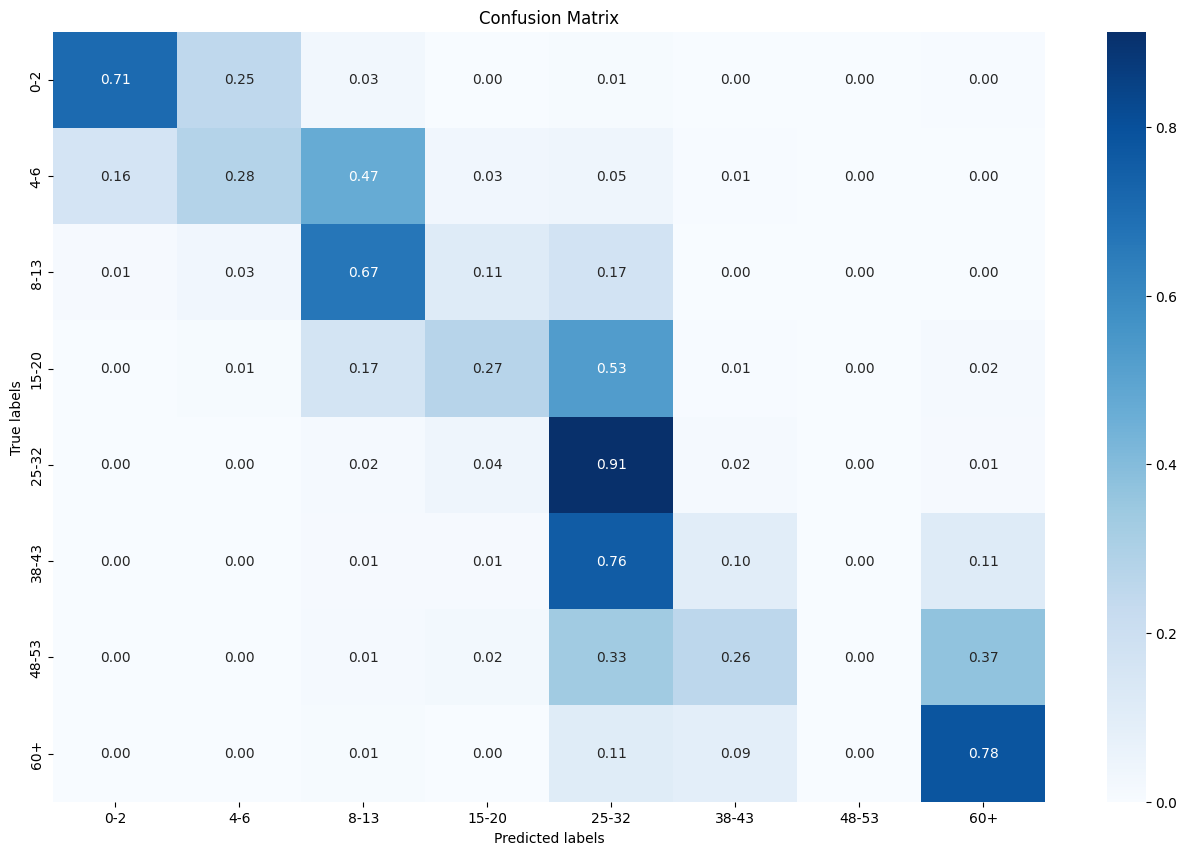

In [33]:
class_names = [
    "0-2",  # Classe 0
    "4-6",  # Classe 1
    "8-13", # Classe 2
    "15-20",# Classe 3
    "25-32",# Classe 4
    "38-43",# Classe 5
    "48-53",# Classe 6
    "60+"   # Classe 7
]

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing

# Plotting
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

In [34]:
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

y_true = all_targets
y_pred = all_predictions

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Accuracy: 0.5867
F1 Score: 0.4437

Classification report:

              precision    recall  f1-score   support

         0-2     0.8541    0.7085    0.7745       223
         4-6     0.3981    0.2810    0.3295       153
        8-13     0.4345    0.6667    0.5261       174
       15-20     0.3553    0.2727    0.3086       198
       25-32     0.6151    0.9127    0.7349      1317
       38-43     0.2601    0.1021    0.1466       568
       48-53     0.0000    0.0000    0.0000       341
         60+     0.6837    0.7822    0.7296       583

    accuracy                         0.5867      3557
   macro avg     0.4501    0.4657    0.4437      3557
weighted avg     0.4930    0.5867    0.5208      3557



### Fonction d'hyperoptimisation

In [ ]:
import optuna

def objective(trial):
    # Hyperparameters to be tuned by Optuna
    hyperparameters = {'lr' : trial.suggest_float('lr', 1e-5, 1e-1, log=True),
                        'weight_decay' : trial.suggest_float('weight_decay', 1e-10, 1e-3, log=True),
                        'step_size' : trial.suggest_int('step_size', 10, 50),
                        'gamma' : trial.suggest_float('gamma', 0.1, 0.9),
                        
    }

    # Existing training and validation code here
    model, valid_loss = train(hyperparameters)

    # Use the validation loss as the value to minimize
    return valid_loss

def hyperoptimize():
    study = optuna.create_study(direction='minimize')  # 'minimize' or 'maximize' depending on your objective
    study.optimize(objective, n_trials=10)  # n_trials is the number of hyperparameter sets to try

    print('Number of finished trials:', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value:', trial.value)
    print('Params:')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    return trial.params.items()

In [ ]:
hyperoptimize()